***You can use the Table of Contents panel on the left sidebar to quickly navigate through the sections of this notebook. Look for the icon that resembles a bulleted list.***

--------------------------------



# LIBRARY IMPORTS

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid

SEED = 1
torch.set_default_dtype(torch.float64)

torch.manual_seed(SEED)


# DEVICE
Configures the device (GPU or CPU) for PyTorch execution.


In [ ]:
if torch.cuda.is_available():
    # Use GPU on Google Colab
    device = torch.device("cuda")

else:
    #CPU
    device = torch.device("cpu")

print("USING ", device)

USING  cuda


# DATA IMPORTS
* Loads the training and testing datasets.
* Just drag and drop the csv files in this Notebook.

In [ ]:
# Importing the datasets
train_data = pd.read_csv("./train_dataset.csv", parse_dates=True, index_col='date')
test_data = pd.read_csv("./test_features.csv", parse_dates=True, index_col='date')

--------------------------------------------
# EDA & PREPROCESSING
Performs Exploratory Data Analysis (EDA) and preprocessing steps on the training data.


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35040 entries, 2022-01-01 00:00:00 to 2022-12-31 23:45:00
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      35040 non-null  int64  
 1   temperature_exterieure  35040 non-null  float64
 2   humidite                35040 non-null  float64
 3   ensoleillement          35040 non-null  float64
 4   vitesse_vent            35040 non-null  float64
 5   direction_vent          35040 non-null  float64
 6   temperature_interieure  35040 non-null  float64
 7   puissance_cvac          35040 non-null  float64
 8   puissance_cvac_future   35040 non-null  object 
dtypes: float64(7), int64(1), object(1)
memory usage: 2.7+ MB


## Missing Values
Checks for missing values in the training dataset.


In [ ]:
# Checking for missing values
train_data.isna().sum()

,0
ID,0
temperature_exterieure,0
humidite,0
ensoleillement,0
vitesse_vent,0
direction_vent,0
temperature_interieure,0
puissance_cvac,0
puissance_cvac_future,0


In [ ]:
train_data['puissance_cvac_future'].value_counts()

,count
puissance_cvac_future,
0.0,4928
missing,16
0.393257822359399,1
0.414696883747897,1
0.441074028827551,1
...,...
1.2314729241623,1
1.20978114049054,1
1.18646154123186,1


There are 16 missing values in `puissance_cvac_future` and we will proceed with preprocessing while keeping that in mind.

## Feature Statistics
Displays descriptive statistics for numerical features.


In [ ]:
# Checking statistical features
train_data.describe()

,ID,temperature_exterieure,humidite,ensoleillement,vitesse_vent,direction_vent,temperature_interieure,puissance_cvac
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,17519.500000,7.924304,67.386287,167.193037,4.538028,187.204481,21.812297,1.529627
std,10115.321053,11.855826,16.626531,272.016185,2.477155,99.617528,0.962409,1.945118
min,0.000000,-23.000000,17.000000,0.000000,0.000000,0.000000,20.506609,0.000000
25%,8759.750000,-1.000000,55.000000,0.000000,2.725000,102.000000,20.999951,0.251010
50%,17519.500000,9.000000,68.000000,0.000000,4.100000,220.000000,21.002978,0.777715
75%,26279.250000,18.000000,81.000000,251.562500,6.000000,265.000000,22.999749,1.881776
max,35039.000000,33.000000,100.000000,978.000000,21.600000,359.500000,26.010427,10.184208


## Feature Distribution
Visualizes the distribution of float-type features.

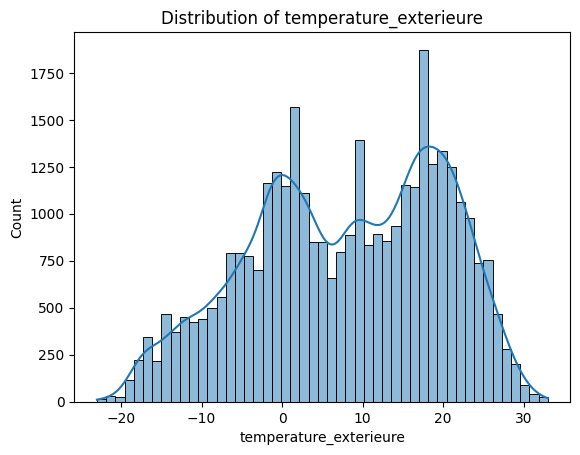

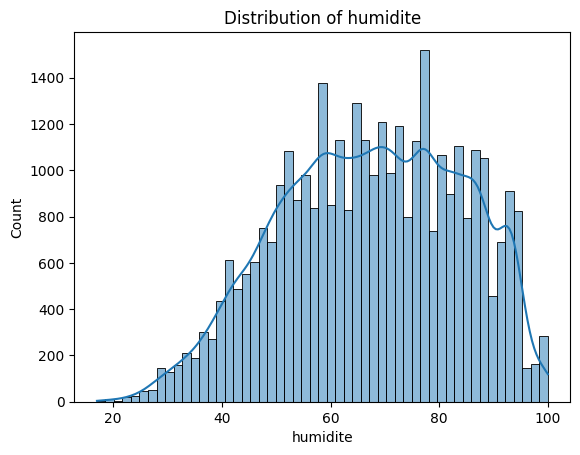

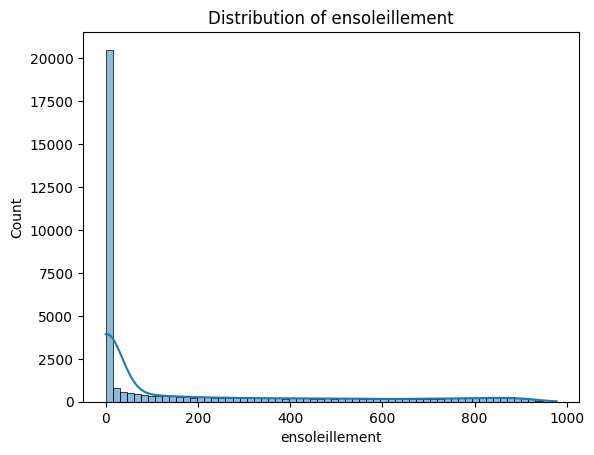

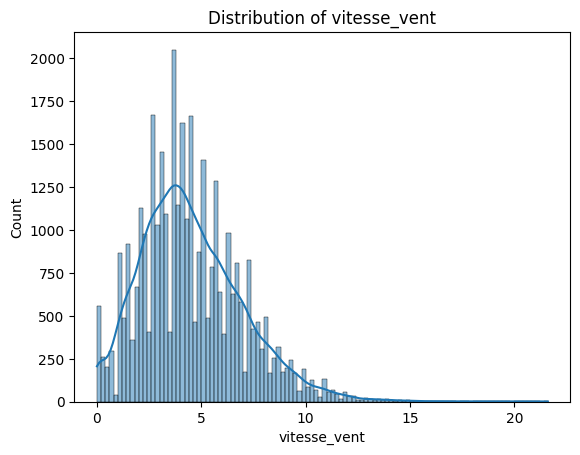

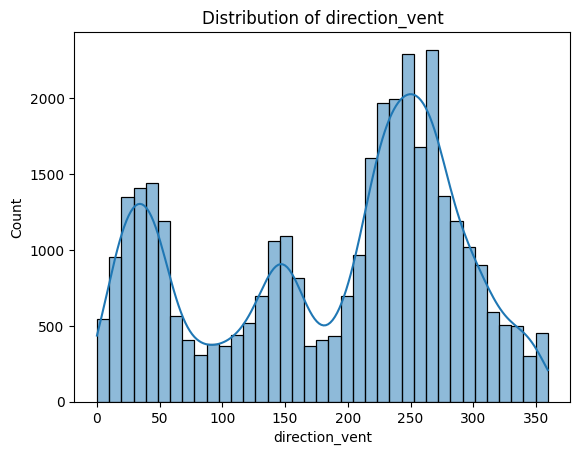

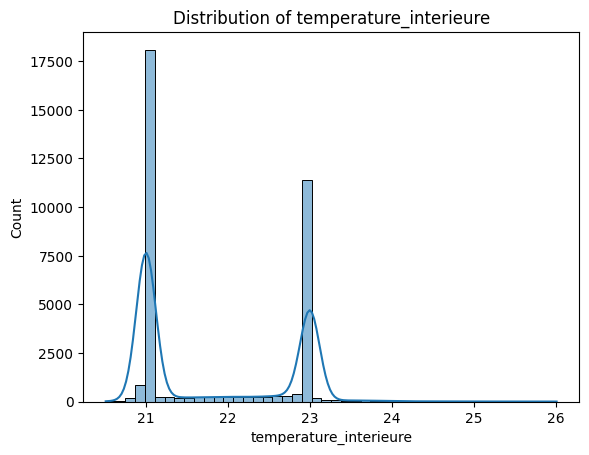

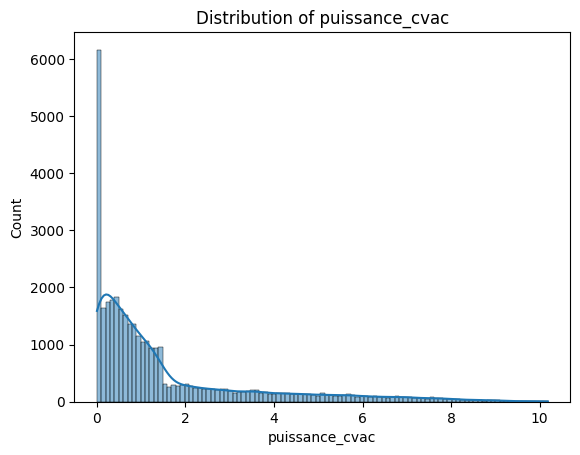

In [ ]:
# Plotting the distribution of float features
float_cols = [col for col in train_data.columns if train_data[col].dtype == 'float64']
for col in float_cols:
    sns.histplot(train_data[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

The cell below visualizes full-year trends using weekly averages of key variables (temperature, humidity, etc.), with shaded bands showing daily variability. it aggregates 15-minute data to weekly means to maintain yearly context while avoiding overplotting. Ideal for identifying seasonal patterns and outlier weeks.

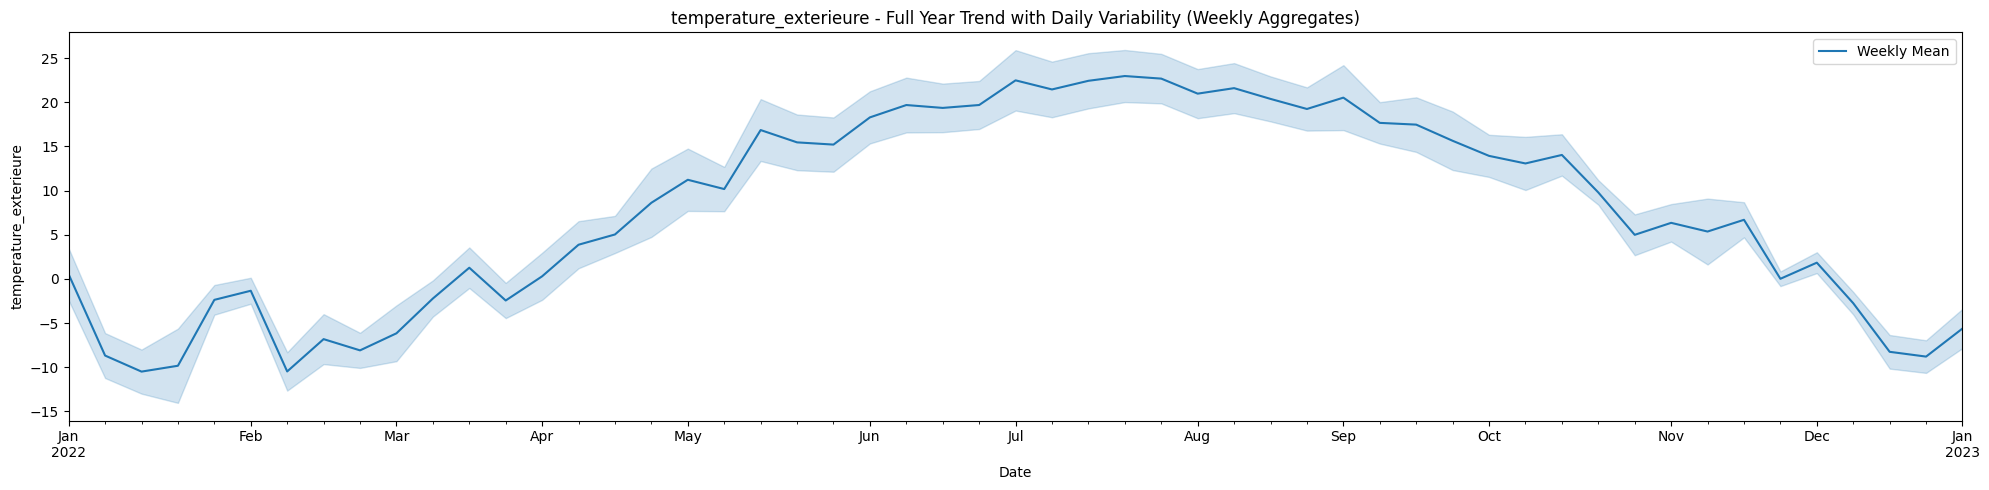

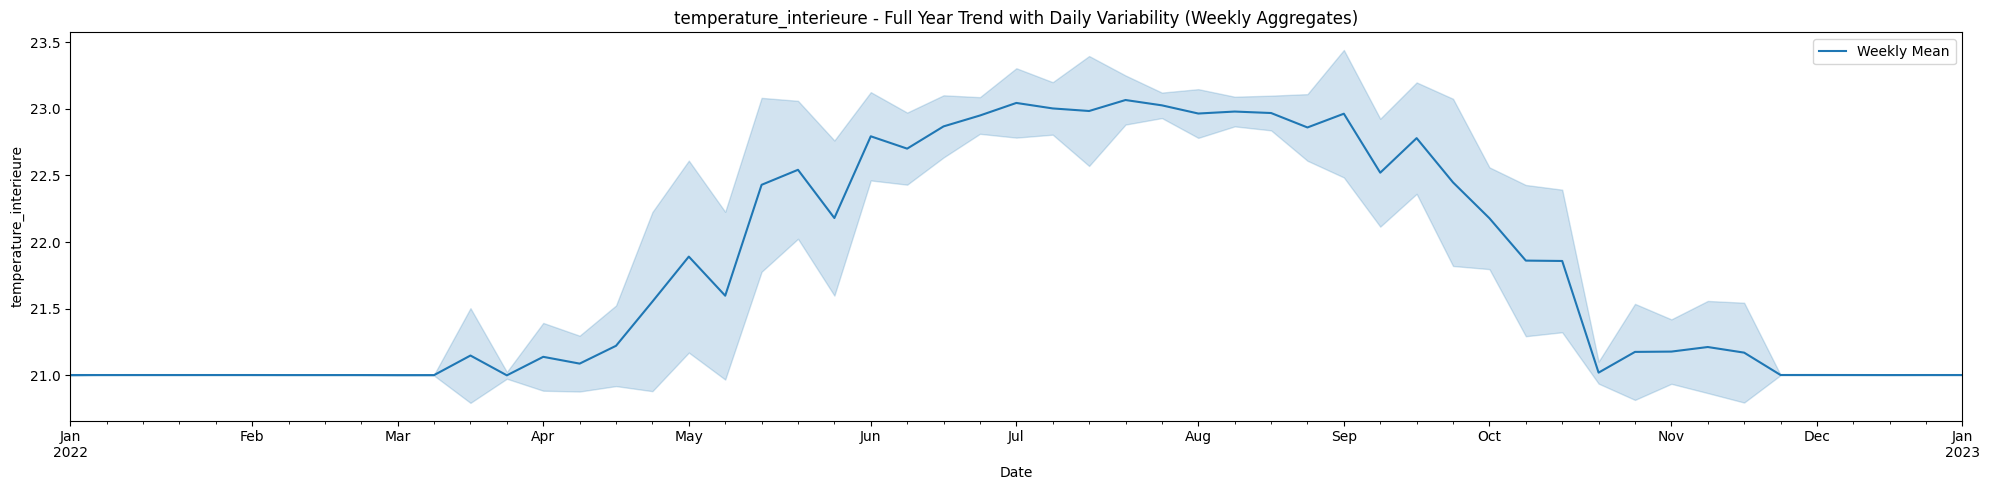

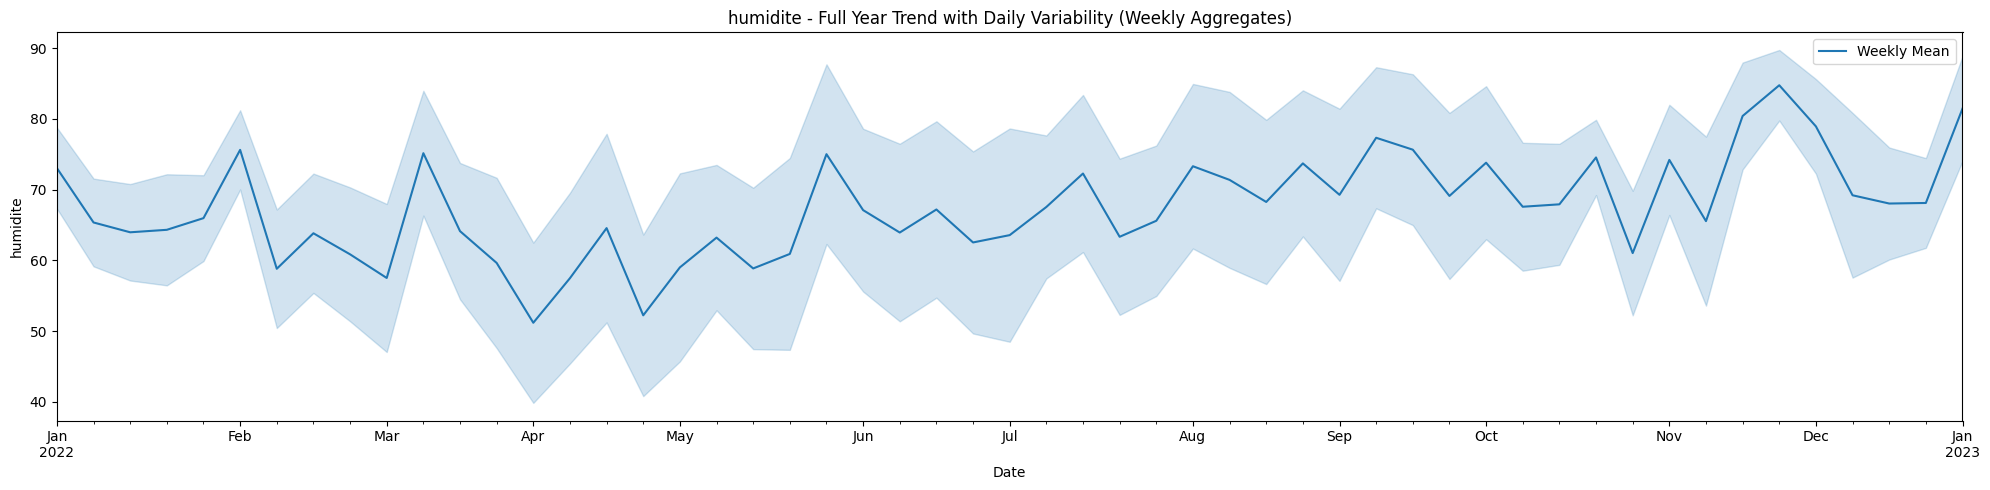

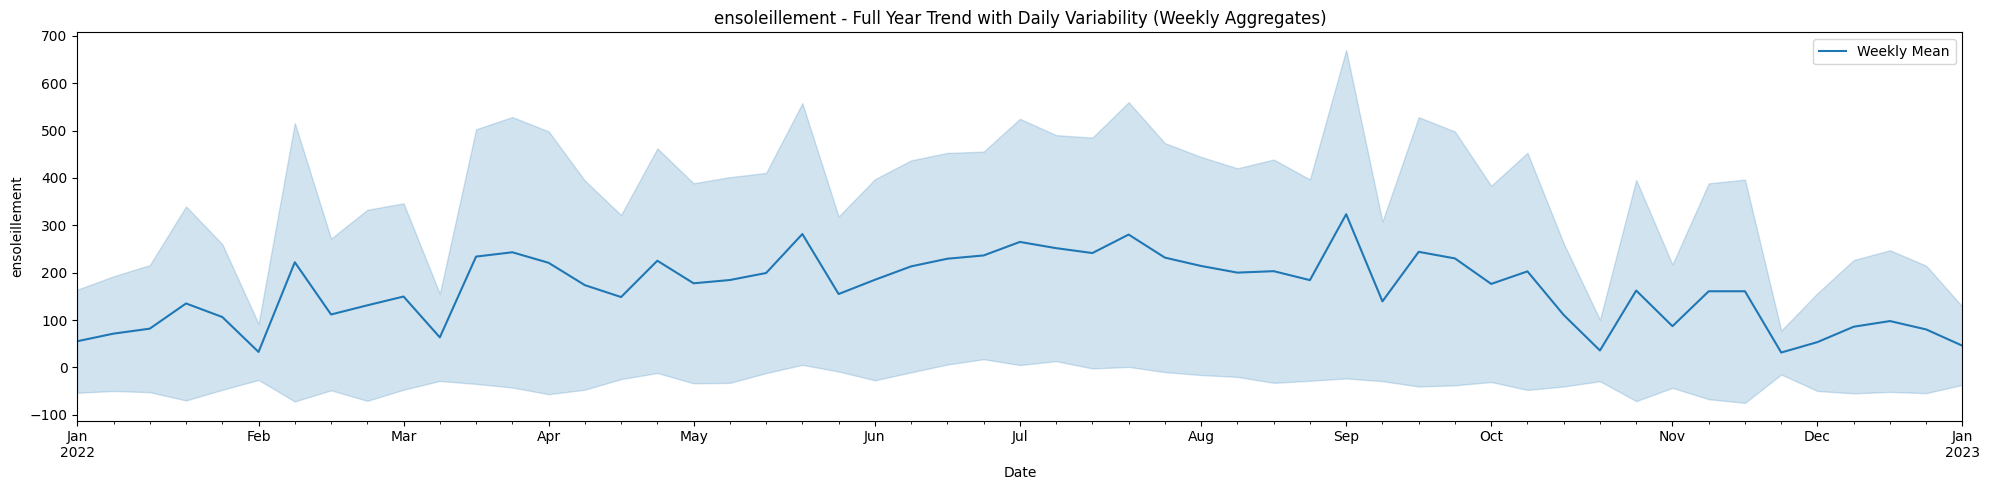

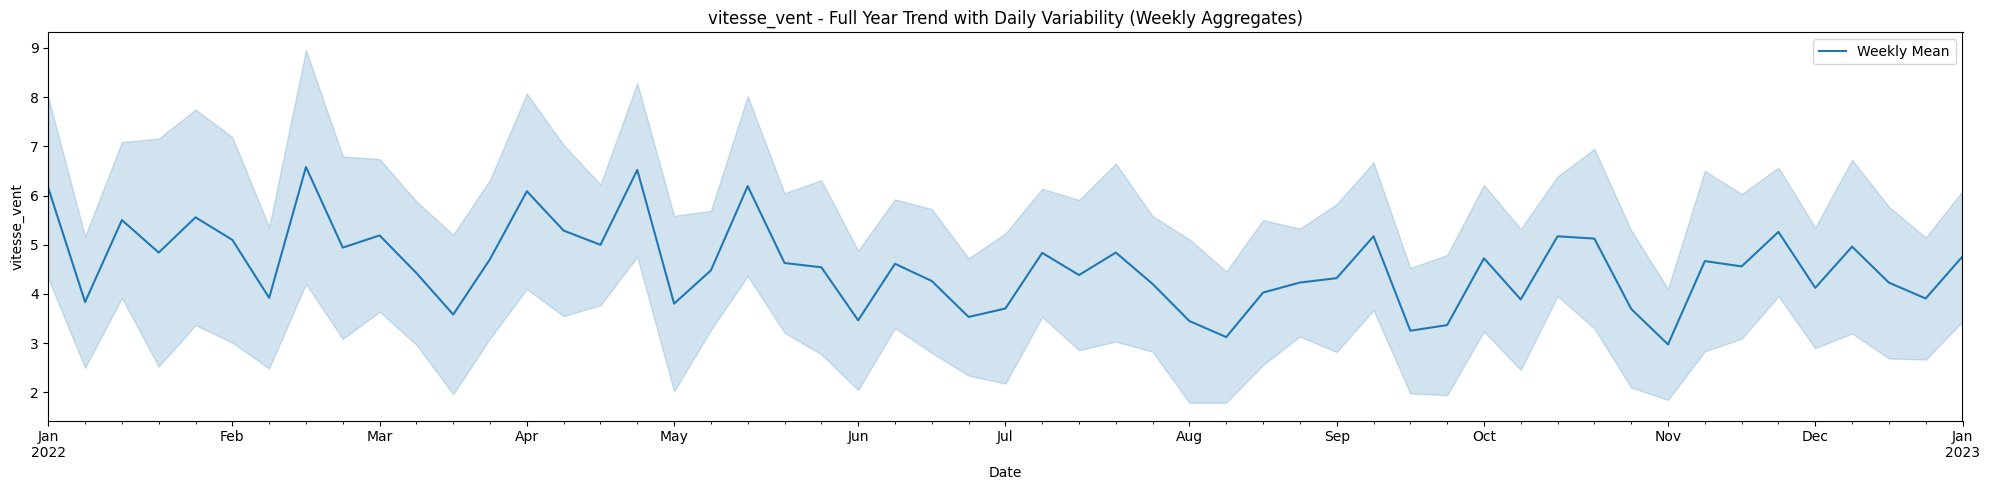

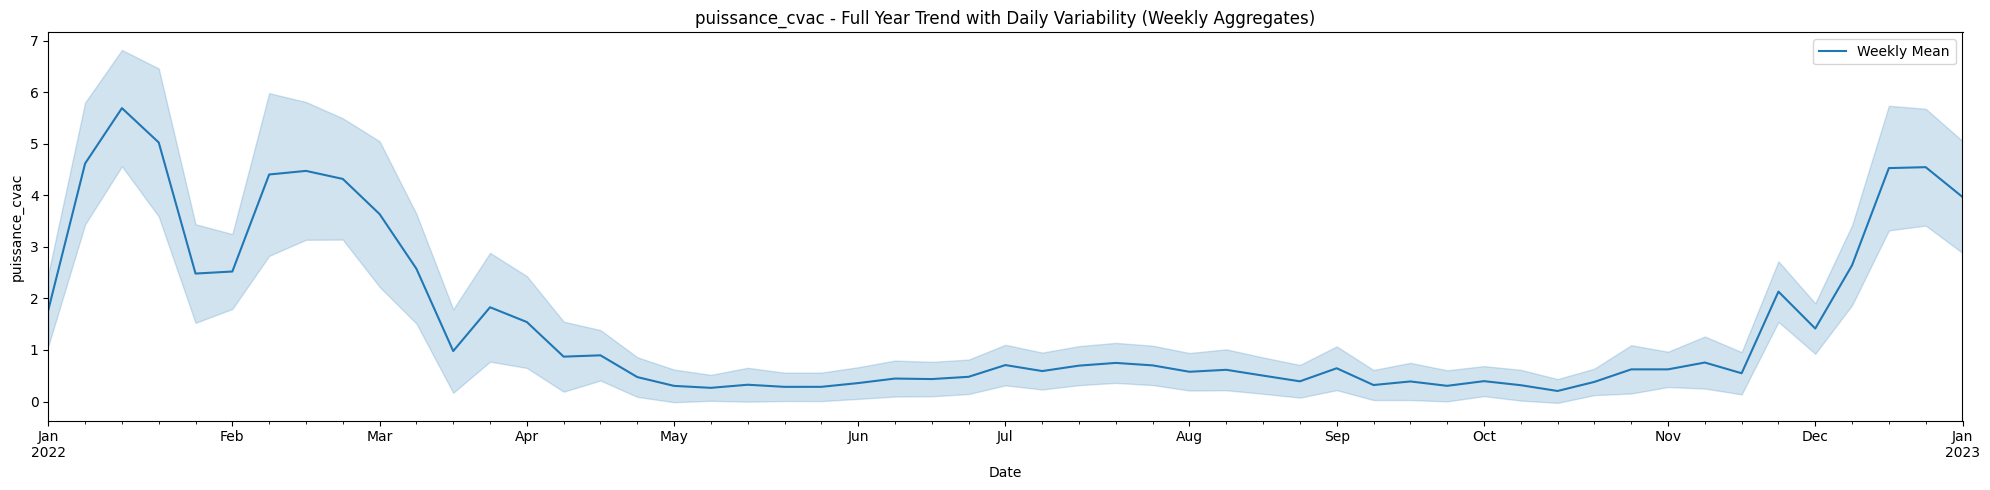

In [ ]:
variables = ['temperature_exterieure', 'temperature_interieure',
              'humidite', 'ensoleillement', 'vitesse_vent', 'puissance_cvac']

for var in variables:
    plt.figure(figsize=(20, 5))

    # Plot weekly averages with daily error bands
    weekly = train_data[var].resample('W').mean()
    daily_std = train_data[var].resample('D').std().resample('W').mean()

    weekly.plot(color='tab:blue', label='Weekly Mean')
    plt.fill_between(weekly.index,
                    weekly - daily_std,
                    weekly + daily_std,
                    color='tab:blue', alpha=0.2)

    plt.title(f'{var} - Full Year Trend with Daily Variability (Weekly Aggregates)')
    plt.xlabel('Date')
    plt.ylabel(var)
    plt.legend()
    plt.tight_layout()
    plt.show()

The following cell shows monthly distributions. Compares median values and interquartile ranges across months, maintaining high temporal resolution while remaining computationally feasible. Critical for identifying monthly operational patterns.

<ipython-input-13-22c5864a68f9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y=var, data=train_data,


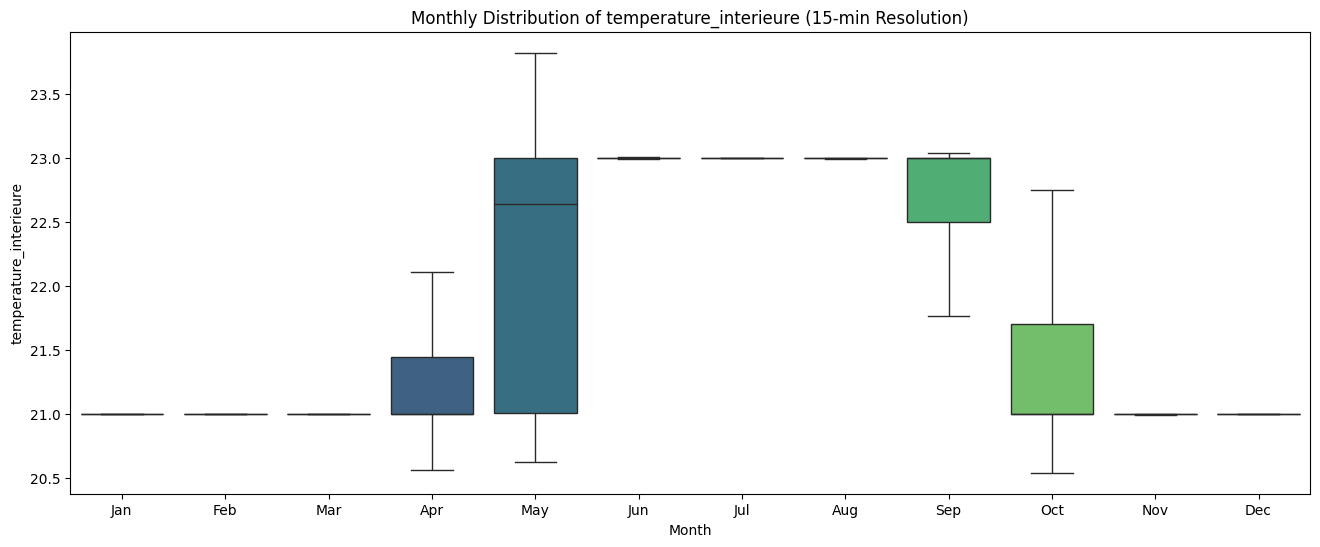

<ipython-input-13-22c5864a68f9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y=var, data=train_data,


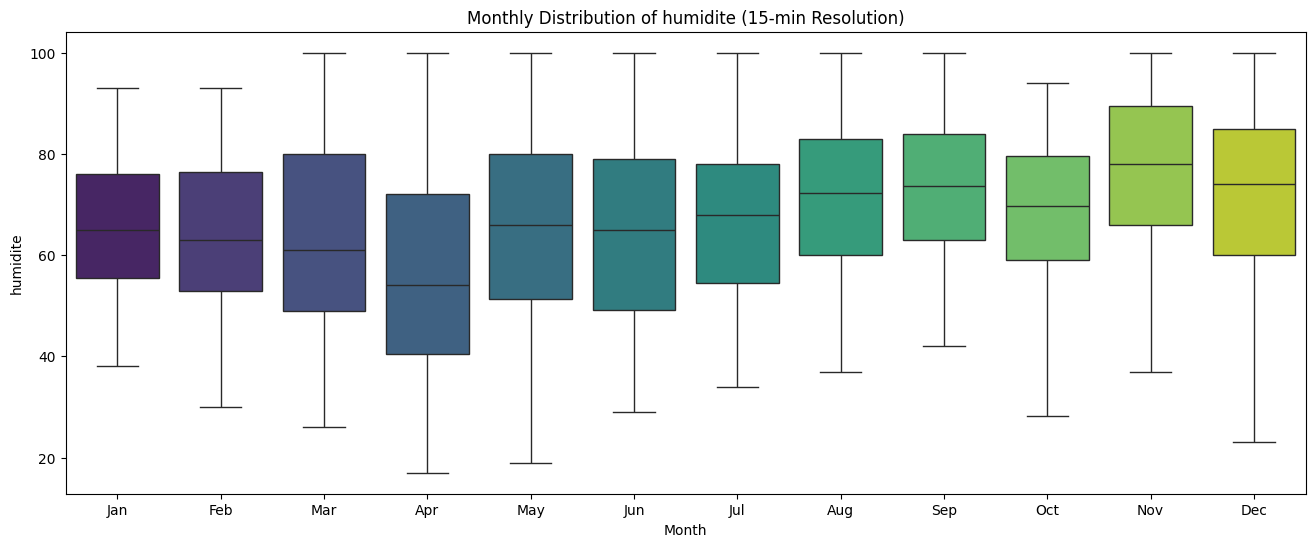

<ipython-input-13-22c5864a68f9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y=var, data=train_data,


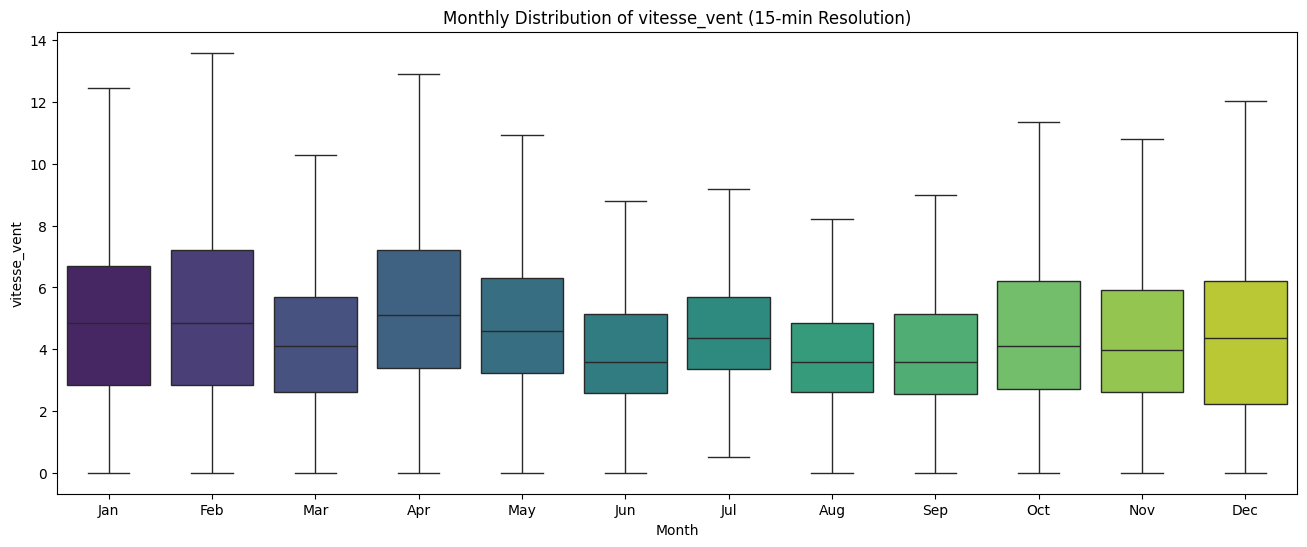

<ipython-input-13-22c5864a68f9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y=var, data=train_data,


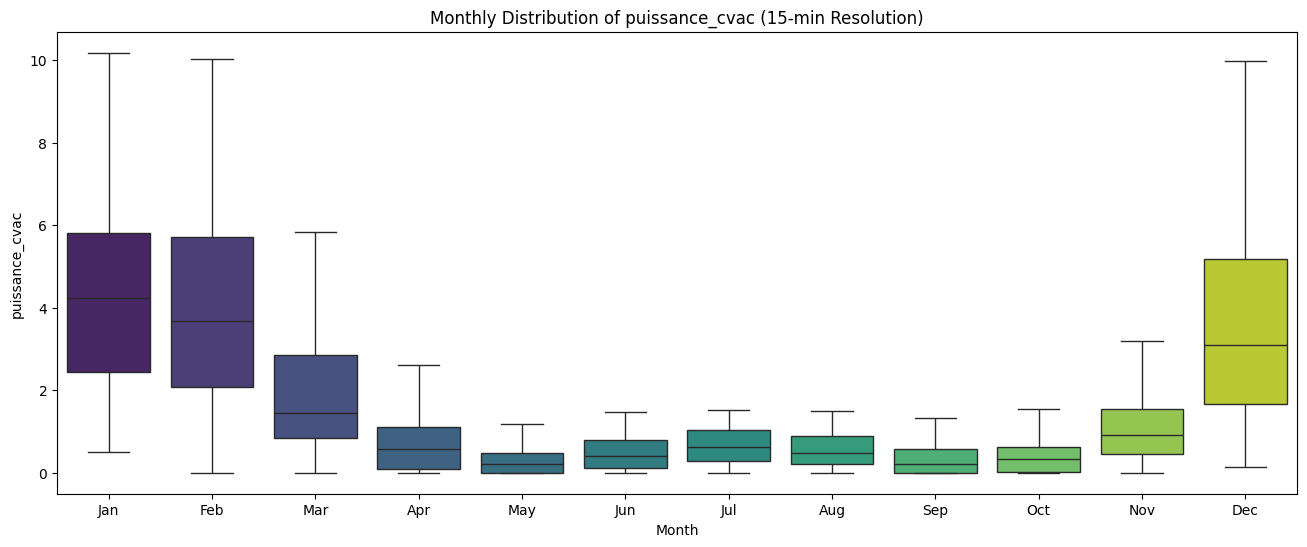

In [ ]:
train_data['month'] = train_data.index.month
variables = ['temperature_interieure', 'humidite',
            'vitesse_vent', 'puissance_cvac']

for var in variables:
    plt.figure(figsize=(16, 6))
    sns.boxplot(x='month', y=var, data=train_data,
                palette='viridis', showfliers=False)  # Suppress outliers for clarity
    plt.title(f'Monthly Distribution of {var} (15-min Resolution)')
    plt.xlabel('Month')
    plt.xticks(ticks=range(12), labels=['Jan','Feb','Mar','Apr','May','Jun',
                                      'Jul','Aug','Sep','Oct','Nov','Dec'])
    plt.ylabel(var)
    plt.show()

As illustrated in the plots above, power consumption is highest in winter. We can also observe that power consumption and interior temperature exhibit greater variability throughout the year compared to humidity and wind speed.

## Correlation between features
Calculates and visualizes the correlation matrix between float features.

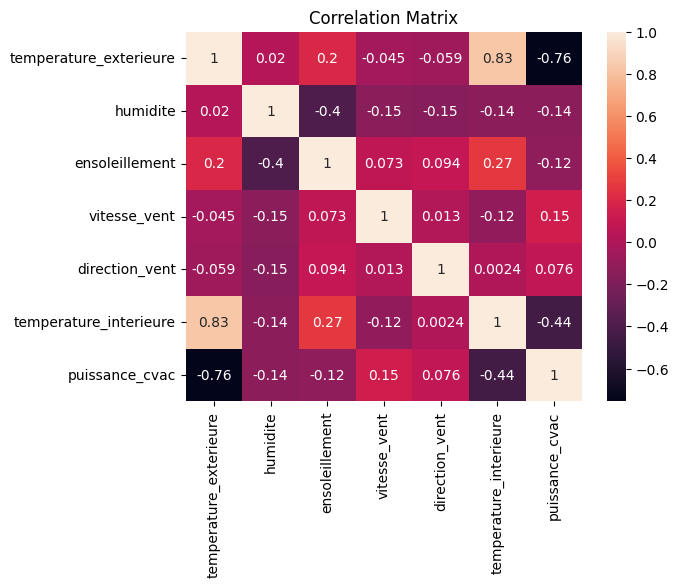

In [ ]:
# Finding correlation between features
corr_mat = train_data[float_cols].corr()
sns.heatmap(corr_mat, annot=True)
plt.title("Correlation Matrix")
plt.show()

We can see that `temperature_interieure` and `temperature_exterieure` have a correlation of high magnitude with eachother and `puissance_cvac`.


## Choosing appropriate features
We also experimented with additional features, such as `is_weekend`—a Boolean indicator of whether a given day falls on a weekend—and applied Fourier transformation on the existing features. However, incorporating these features did not improve the model's performance and therefore we will refrain from utilizing them.

In [ ]:
kept_features_test = [ "temperature_exterieure","humidite","ensoleillement","vitesse_vent","direction_vent","temperature_interieure"]
kept_features_train = kept_features_test+ ["puissance_cvac"]

-----------------------------------------------
# HELPER FUNCTIONS
Defines several utility functions for data processing and model training.

##Data Predictions
Function to generate predictions on the data using a trained model.
For each 16seq it generates 16seq predictions and given we work with overlapping windows for an observation we will have 16 predictions so we average the values to get the pr'ediction for that observation.


In [ ]:
def make_predictions(test_input_data, model):
    """
    Generates predictions on the test data.

    Parameters:
      test_input_data:
             list of tuples (start_index, tensor_window) where tensor_window has shape (window_size, features).
      model: trained LSTM model that takes as input a tensor of shape (batch, seq_len, features)
             and outputs a tensor of shape (batch, seq_len, features).

    Returns:
         a list of tensors aggregated by time step.
    """
    model.eval()

    # For overlapping windows, accumulate predictions for each time step
    predictions_accum = {}
    #print("Overlapping mode activated (overlapping windows with stride=1) :")
    for start_idx, window in test_input_data:
        input_seq = window.double().unsqueeze(0).to(device)
        #print(f"Window starting at index {start_idx}:")
        ##print(window)
        with torch.no_grad():
            block_pred = model(input_seq)
        block_pred = block_pred.squeeze(0).cpu()
        #print(f"Prediction for window starting at {start_idx}:")
        #print(block_pred)
        # Assign each prediction to the corresponding time step
        for offset, pred in enumerate(block_pred):
            time_step = start_idx + offset
            if time_step in predictions_accum:
                predictions_accum[time_step].append(pred)
            else:
                predictions_accum[time_step] = [pred]

    # Calculate the average of predictions for each time step
    final_predictions = []
    for time_step in sorted(predictions_accum.keys()):
        preds_tensor = torch.stack(predictions_accum[time_step], dim=0)
        mean_pred = preds_tensor.mean(dim=0)
        final_predictions.append(mean_pred)
    return final_predictions

## Generate Overlapping Windows
Function to create sliding (overlapping) time series data windows.

In [ ]:
def generate_overlapping_windows(data, window_size, stride=1, Drop_last_column = False ):
    '''
    Generates overlapping windows from the input DataFrame.

    Params:
    - data: input DataFrame
    - window_size: number of time steps per window
    - stride: step size between windows (default: 1)
    - Drop_last_column: if True, excludes the last column

    Returns:
    - List of (start_index, tensor_window) tuples
    '''
    # Overlapping windows: stride is usually 1 for maximum overlap.
    windows = []
    for i in range(0, len(data) - window_size + 1, stride):
        if Drop_last_column :
            window = torch.tensor(data.iloc[i:i+window_size, :-1].values)
        else :
            window = torch.tensor(data.iloc[i:i+window_size, :].values)
        windows.append((i, window))  # Keep track of the starting index.
    return windows

## Add Cyclical Features
Function to add cyclical (sin/cos) features for hour, day of year, and wind direction.


In [ ]:
def add_cyclical_features(df, drop_raw=True):
    """
    Adds cyclical (sine/cosine) encoding of hour-of-day, day-of-year, and direction_vent.
    Assumes the index is a DateTimeIndex.

    Parameters:
        df (pd.DataFrame): The input DataFrame with a DateTimeIndex.
        drop_raw (bool): If True, the raw columns ('hour', 'day_of_year', 'direction_vent') are dropped.

    Returns:
        pd.DataFrame: The modified DataFrame with cyclical features.
    """
    # 1. Extract hour and day_of_year from the index
    df['hour'] = df.index.hour
    df['day_of_year'] = df.index.day_of_year

    # 2. Encode hour-of-day
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # 3. Encode day-of-year
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

    # 4. Encode direction_vent if present
    if 'direction_vent' in df.columns:
        df['direction_vent_sin'] = np.sin(2 * np.pi * df['direction_vent'] / 360)
        df['direction_vent_cos'] = np.cos(2 * np.pi * df['direction_vent'] / 360)

    # 5. Drop raw features if requested
    raw_cols_to_drop = []
    if drop_raw:
        raw_cols_to_drop += ['hour', 'day_of_year']
        if 'direction_vent' in df.columns:
            raw_cols_to_drop.append('direction_vent')
        df.drop(columns=raw_cols_to_drop, inplace=True)

    # 6. Build list of cyclical columns in order
    cyclical_cols = ['hour_sin', 'hour_cos', 'day_of_year_sin', 'day_of_year_cos']
    if 'direction_vent_sin' in df.columns and 'direction_vent_cos' in df.columns:
        cyclical_cols += ['direction_vent_sin', 'direction_vent_cos']

    # 7. Reorder columns
    if 'puissance_cvac_future' in df.columns:
        new_order = (
            cyclical_cols +
            [col for col in df.columns if col not in cyclical_cols and col != 'puissance_cvac_future'] +
            ['puissance_cvac_future']
        )
    else:
        new_order = cyclical_cols + [col for col in df.columns if col not in cyclical_cols]

    return df[new_order]

## Create Input/Output Sequences
Function to transform data into input (X) and output (y) sequences for the LSTM model, depending if it's for pre_model training then targets are the note shifted, if they are for the main model training the targets are shifted (+16 steps).

In [ ]:
def create_sequences(df, n_in, n_out,pre_train=False):
    """
    Builds sequences of length n_in (input features)
    followed by length n_out (target only).

    Returns:
        X: shape (num_samples, n_in, num_input_features)
        y: shape (num_samples, n_out) or (num_samples, n_out, 1)
    """
    data_arr = df.values

    # Indices of columns: the last column is the target (puissance_cvac)
    # All columns except last are the input features.
    # If you want them all as inputs, just separate them accordingly:
    if not(pre_train) :
        input_features = data_arr  # all columns except target
    else:
        input_features = data_arr[:, :-1]
    target_column  = data_arr[:,  -1]  # just the target

    X, y = [], []
    max_i = len(df) - (n_in + n_out)

    for i in range(max_i):
        # past n_in steps
        seq_X = input_features[i : i + n_in]

        if pre_train :
            seq_y = target_column[i  : i + n_out]
        else :
            seq_y = target_column[i + n_in : i + n_in + n_out]
        X.append(seq_X)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    y = y[..., np.newaxis]

    return X, y

## Plot Cross-Validation Losses
Function to visualize the loss curves (training and validation) for each cross-validation fold and their average.


In [ ]:
def plot_cv_losses(title,train_fold_results_pre, val_fold_results_pre):
    """
    Plots the loss curves for each fold (train and val),
    then the average over all folds.

    Parameters:
      - train_fold_results_pre: list of lists,
          train_fold_results_pre[i] = [loss_epoch1, ..., loss_epochN] for fold i
      - val_fold_results_pre:   list of lists, same structure as train_fold_results_pre
    """

    n_splits = len(train_fold_results_pre)
    if n_splits == 0:
        print("No fold was recorded.")
        return

    num_epochs = len(train_fold_results_pre[0])
    epochs = range(1, num_epochs + 1)

    # ==========================================
    # 1) Plot the Train/Val curves for EACH fold
    # ==========================================
    plt.figure(figsize=(10, 6))
    for i in range(n_splits):
        plt.plot(epochs, train_fold_results_pre[i], label=f"Train Fold {i+1}")
        plt.plot(epochs, val_fold_results_pre[i], label=f"Val Fold {i+1}", linestyle="--")

    plt.title("Train/Val Loss for fold : " + title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ==========================================
    # 2) Plot the AVERAGE across folds
    # ==========================================
    train_array = np.array(train_fold_results_pre)
    val_array   = np.array(val_fold_results_pre)

    mean_train = np.mean(train_array, axis=0)
    mean_val   = np.mean(val_array,   axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, mean_train, label="Average Train Loss", marker="o")
    plt.plot(epochs, mean_val,   label="Average Val Loss",   marker="x")
    plt.title("Train/Val Loss Average (across all folds) "+ title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

## Apply Teacher Forcing Strategy
Function to apply different teacher forcing strategies during training data preparation.


In [ ]:
def apply_teacher_forcing(
    df: pd.DataFrame,
    pred_array: np.ndarray,
    teacher_forcing_method: str = "schedule",
    p: float = 0.5,
    target_column: str = "puissance_cvac"
) -> pd.DataFrame:
    """
    Applies a teacher forcing strategy to a DataFrame for the `target_column`.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame (contains the target column `target_column`).
    pred_array : np.ndarray
        Array (1D or 2D) of predictions, same length as df.
    teacher_forcing_method : str
        Method to use from {"average", "schedule", "predicted", "true"}.
    p : float
        Probability of using the prediction (in the "schedule" case).
    target_column : str
        Name of the target column in `df`.

    Returns
    -------
    df_forfutur : pd.DataFrame
        A copy of `df`, in which the `target_column` has been
        modified according to the teacher forcing method.
    """

    # Start from a copy to avoid modifying the original
    df_teacher_forced= df.copy()

    # Simple check: verify that the size of pred_array matches the number of rows in df
    if len(pred_array) != len(df_teacher_forced):
        raise ValueError(
            f"pred_array has a length ({len(pred_array)}) "
            f"different from df ({len(df_teacher_forced)})"
        )

    if teacher_forcing_method == "average":
        # Average approach: new value = (true value + prediction) / 2
        df_teacher_forced[target_column] = (
            df_teacher_forced[target_column].values + pred_array
        ) / 2.0
        print("Average approach used.")

    elif teacher_forcing_method == "schedule":
        # Scheduled sampling: randomly choose between the true value and the prediction
        random_mask = np.random.rand(len(df_teacher_forced)) < p
        new_values = np.where(
            random_mask,
            pred_array,
            df_teacher_forced[target_column].values
        )
        df_teacher_forced[target_column] = new_values
        print(f"Scheduled sampling used (p = {p}).")

    elif teacher_forcing_method == "predicted":
        # Only using predicted values
        df_teacher_forced[target_column] = pred_array
        print("Only using predicted values.")

    elif teacher_forcing_method == "true":
        # Keep the true values (no modification)
        print("Only using true values.")

    else:
        raise ValueError(
            f"The method teacher_forcing_method is invalide : {teacher_forcing_method}. "
            "Use one of the following options : average, schedule, predicted, true."
        )

    return df_teacher_forced

## Prepare Data Fold for Pre-training/Training
Function to prepare data for a specific cross-validation fold (splitting, scaling, sequence creation, and DataLoaders).

In [ ]:
def prepare_pre_data_fold(
    train_data,
    train_idx,
    val_idx,
    kept_features_train,
    kept_features_test,
    n_steps_in,
    n_steps_out,
    batch_size,
    pre_train
):
    """
    This function performs:
      1) Temporal split (train_df, val_df) based on indices.
        If val_idx is None,
         then the entire train_data is used for training (train_df), and val_df will be set to None.
      2) Normalization (fit on training set, transform on validation set if defined)
      3) Sequence creation (X, y) via create_sequences
      4) Construction of DataLoaders for training and validation (validation is None if there is no split)
      5) Calculation of mean/scale specific to kept_features_test.

    Returns:
      - train_df (normalized)
      - val_df (normalized or None)
      - scaler (trained on train_df)
      - train_loader_pre (DataLoader)
      - val_loader_pre (DataLoader or None)
      - common_mean, common_scale (in case you need them later)
    """
    # ================================
    # 1) Train / validation split
    # ================================
    if val_idx is None:
        # If no validation index is provided, use the entire dataset for training.
        train_df = train_data.copy()
        val_df = None
    else:
        train_df = train_data.iloc[train_idx].copy()
        val_df   = train_data.iloc[val_idx].copy()

    # ================================
    # 2) Normalization (StandardScaler)
    # ================================
    scaler = StandardScaler()
    train_df[kept_features_train] = scaler.fit_transform(train_df[kept_features_train])

    if val_df is not None:
        val_df[kept_features_train] = scaler.transform(val_df[kept_features_train])

    # Retrieve the indices corresponding to the test columns
    common_indices = [kept_features_train.index(col) for col in kept_features_test]
    common_mean   = scaler.mean_[common_indices]
    common_scale  = scaler.scale_[common_indices]

    # ================================
    # 3) Sequence creation
    # ================================
    X_train_pre, y_train_pre = create_sequences(train_df, n_steps_in, n_steps_out, pre_train)
    if val_df is not None:
        X_val_pre, y_val_pre = create_sequences(val_df, n_steps_in, n_steps_out, pre_train)
    else:
        X_val_pre, y_val_pre = None, None

    # ================================
    # 4) Convert to tensors + DataLoaders
    # ================================
    X_tensor_pre = torch.from_numpy(X_train_pre).double()
    y_tensor_pre = torch.from_numpy(y_train_pre).double()
    train_dataset_pre = TensorDataset(X_tensor_pre, y_tensor_pre)
    train_loader_pre = DataLoader(train_dataset_pre, batch_size=batch_size, shuffle=True)

    if X_val_pre is not None:
        X_val_t_pre = torch.from_numpy(X_val_pre).double()
        y_val_t_pre = torch.from_numpy(y_val_pre).double()
        val_dataset_pre = TensorDataset(X_val_t_pre, y_val_t_pre)
        val_loader_pre = DataLoader(val_dataset_pre, batch_size=batch_size, shuffle=False)
    else:
        val_loader_pre = None

    # ================================
    # 5) Return the important items
    # ================================
    return (train_df,
            val_df,
            scaler,
            train_loader_pre,
            val_loader_pre,
            common_mean,
            common_scale)

## Optimal Hyperparameter selection
Function to analyze grid search results and determine the best hyperparameter combination for pre-model and main model based on average validation loss.




In [ ]:
def get_best_results_separately(grid_search_results):
    """
    Evaluate grid search results across cross-validation folds for pre-model and main model separately.
    For each parameter combination, compute the mean validation loss per epoch (averaged over folds)
    and then determine the best configuration (i.e., parameters, epoch, and mean loss) for:
      1. Pre-model validation losses (key: 'val_fold_results_pre')
      2. Main model validation losses (key: 'val_fold_results')

    When the best model is found, plots are generated using the provided plot_cv_losses() function.

    Additionally, the function extracts individual hyperparameter values (optimal grid-search values)
    and returns them in a 'details' sub-dictionary for each model.

    Parameters
    ----------
    grid_search_results : list of dict
        Each dictionary corresponds to a grid search parameter combination containing:
          - 'params': dictionary of hyperparameters.
          - 'val_fold_results_pre': list of lists of pre-model validation losses (each inner list is per epoch for a given fold).
          - 'val_fold_results': list of lists of main-model validation losses (each inner list is per epoch for a given fold).
          - 'train_fold_results_pre': list of lists of pre-model training losses.
          - 'train_fold_results': list of lists of main-model training losses.

    Returns
    -------
    dict
        A dictionary with two keys:
          - "best_pre": A dictionary with keys "params", "epoch", "mean_val_loss", and "details" for the pre-model.
          - "best_main": A dictionary with keys "params", "epoch", "mean_val_loss", and "details" for the main model.
    """

    best_pre_loss = float('inf')
    best_pre_params = None
    best_pre_epoch = None
    best_pre_train_results = None
    best_pre_val_results = None

    best_main_loss = float('inf')
    best_main_params = None
    best_main_epoch = None
    best_main_train_results = None
    best_main_val_results = None

    # Loop over each grid search result entry.
    for result in grid_search_results:
        params = result.get('params', {})

        # --- Evaluate pre-model validation losses ---
        pre_val_losses = result.get('val_fold_results_pre', [])
        if pre_val_losses and len(pre_val_losses) > 0:
            # Assuming each fold provides losses for the same number of epochs.
            n_epochs_pre = len(pre_val_losses[0])
            mean_losses_pre = []
            for epoch in range(n_epochs_pre):
                # Gather the validation loss for current epoch over all folds.
                epoch_losses = [fold[epoch] for fold in pre_val_losses]
                mean_loss = sum(epoch_losses) / len(epoch_losses)
                mean_losses_pre.append(mean_loss)

            # Find the epoch with the minimum mean validation loss.
            min_loss_pre = min(mean_losses_pre)
            best_epoch_pre = mean_losses_pre.index(min_loss_pre) + 1  # 1-indexed

            # Update best pre-model result if current configuration is better.
            if min_loss_pre < best_pre_loss:
                best_pre_loss = min_loss_pre
                best_pre_params = params
                best_pre_epoch = best_epoch_pre
                best_pre_train_results = result.get('train_fold_results_pre', [])
                best_pre_val_results = pre_val_losses

        # --- Evaluate main-model validation losses ---
        main_val_losses = result.get('val_fold_results', [])
        if main_val_losses and len(main_val_losses) > 0:
            n_epochs_main = len(main_val_losses[0])
            mean_losses_main = []
            for epoch in range(n_epochs_main):
                epoch_losses = [fold[epoch] for fold in main_val_losses]
                mean_loss = sum(epoch_losses) / len(epoch_losses)
                mean_losses_main.append(mean_loss)

            min_loss_main = min(mean_losses_main)
            best_epoch_main = mean_losses_main.index(min_loss_main) + 1  # 1-indexed

            # Update best main model result if current configuration is better.
            if min_loss_main < best_main_loss:
                best_main_loss = min_loss_main
                best_main_params = params
                best_main_epoch = best_epoch_main
                best_main_train_results = result.get('train_fold_results', [])
                best_main_val_results = main_val_losses

    # Plot the best pre-model results if available.
    if best_pre_train_results is not None and best_pre_val_results is not None:
        print("Best pre-model parameters:")
        print(best_pre_params)
        print("Achieved at epoch:", best_pre_epoch)
        print("Mean Validation Loss:", best_pre_loss)
        plot_cv_losses("PRE_MODEL", best_pre_train_results, best_pre_val_results)
    else:
        print("No pre-model results found.")

    # Plot the best main-model results if available.
    if best_main_train_results is not None and best_main_val_results is not None:
        print("Best main-model parameters:")
        print(best_main_params)
        print("Achieved at epoch:", best_main_epoch)
        print("Mean Validation Loss:", best_main_loss)
        plot_cv_losses("MAIN_MODEL", best_main_train_results, best_main_val_results)
    else:
        print("No main model results found.")

    # Extract individual optimal hyperparameter values from the best configurations.
    best_pre_details = {}
    if best_pre_params:
        best_pre_details = {
            "hidden_size_pre_optim": best_pre_params.get("hidden_size_pre"),
            "num_layers_pre_optim": best_pre_params.get("num_layers_pre"),
            "learning_rate_pre_optim": best_pre_params.get("learning_rate_pre"),
            "dropout_value_pre_optim": best_pre_params.get("dropout_value_pre"),
            "num_epochs_pre_optim": best_pre_epoch,
            "method_teacher_optim": best_pre_params.get("method_teacher"),
            "proba_teacher_optim": best_pre_params.get("proba_teacher"),
        }

    best_main_details = {}
    if best_main_params:
        best_main_details = {
            "hidden_size_optim": best_main_params.get("hidden_size"),
            "num_layers_optim": best_main_params.get("num_layers"),
            "learning_rate_optim": best_main_params.get("learning_rate"),
            "dropout_value_optim": best_main_params.get("dropout_value"),
            "num_epochs_optim": best_main_epoch,
        }

    return {
        "best_pre": {
            "params": best_pre_params,
            "epoch": best_pre_epoch,
            "mean_val_loss": best_pre_loss,
            "details": best_pre_details,
        },
        "best_main": {
            "params": best_main_params,
            "epoch": best_main_epoch,
            "mean_val_loss": best_main_loss,
            "details": best_main_details,
        }
    }

In [ ]:
train_data= train_data[kept_features_train]
train_data=add_cyclical_features(train_data)

test_data = test_data[kept_features_test]
test_data=add_cyclical_features(test_data)
if "direction_vent" in kept_features_test :
    kept_features_test.remove("direction_vent")
    kept_features_train.remove("direction_vent")
    #removing it after we created a it's cyclical encoding ...

<ipython-input-18-47985d13f297>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-18-47985d13f297>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_year'] = df.index.day_of_year


-------------------------------------------
# MODEL DEFINITION

After evaluating various models, including Linear Regression and RNNs, the LSTM consistently yielded the best performance. Therefore, we will now focus on optimizing its hyperparameters.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(
        self, input_size, hidden_size, num_layers, n_steps_out=16, output_size=1, dropout_value=0
    ):
        """
        input_size: number of input features at each timestep
        hidden_size: dimensionality of LSTM's hidden state
        num_layers: how many stacked LSTM layers
        n_steps_out: how many future timesteps to predict
        output_size: how many output channels at each predicted timestep (1 in your case)
        dropout_value: dropout rate used in the LSTM layers
        """
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.n_steps_out = n_steps_out
        self.output_size = output_size

        # The LSTM
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_value
        )

        # If multiple layers, we concatenate the hidden states from each layer.
        # If only one layer, the input dimension remains hidden_size.
        if num_layers == 1:
            fc_input_dim = hidden_size
        else:
            fc_input_dim = hidden_size * num_layers

        # A fully connected layer to map from the aggregated hidden state to the n_steps_out * output_size
        self.fc = nn.Linear(fc_input_dim, n_steps_out * output_size)

    def forward(self, x):
        """
        x shape: (batch_size, n_steps_in, input_size)
        """

        out, (h, c) = self.lstm(x)

        if self.num_layers == 1:
            # Use the final hidden state of the single layer
            h_final = h[-1]  # shape: (batch_size, hidden_size)
        else:
            # Concatenate the final hidden states of all layers along the feature dimension
            h_final = torch.cat([h[i] for i in range(self.num_layers)], dim=1)


        # Fully connected layer mapping aggregated hidden state to n_steps_out * output_size
        fc_out = self.fc(h_final)

        # Reshape to (batch_size, n_steps_out, output_size)
        fc_out = fc_out.view(-1, self.n_steps_out, self.output_size)

        return fc_out

-----------------------------------------------
#  GRID SEARCH & CROSS VALIDATION
Sets up and runs the grid search combined with cross-validation to find the best hyperparameters.


## Grid Search activation

In [ ]:
# Set to True to activate the grid search (and cross-val)
grid_search = False

## Hyperparameters settings not included in the grid search

In [ ]:
# Setting some fixed hyperparameters
n_steps_in = 16
n_steps_out = 16
num_epochs_pre = 20
num_epochs = 20

n_splits=5
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M")



## Time Series Cross-Validation Setup

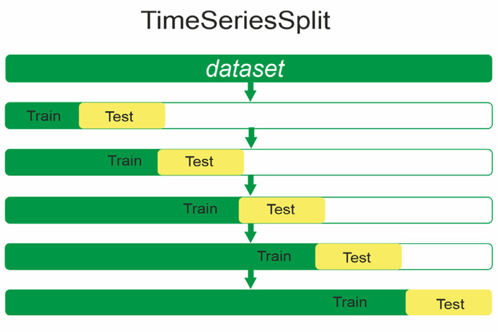

The cell below creates a time series cross-validator object.

- The dataset will be split into 5 consecutive folds.
- max_train_size is set to None removes limitations on the size of the training set. Each successive fold will include more training data (i.e., cumulative expansion).
- gap = 16 adds a "gap" of 16 time steps between the end of the training set and the start of the validation set for each fold. This simulates a forecasting delay and helps prevent data leakage from future information.

In [ ]:
if grid_search :
    tscv = TimeSeriesSplit(n_splits=5, max_train_size=None, gap=16)

## Grid search parameters
Defines the grid of hyperparameters to test for the pre-model, main model, and teacher forcing strategy.


In [ ]:
if grid_search :
    param_grid = {
        'hidden_size_pre':     [128],
        'num_layers_pre':      [ 2],
        'learning_rate_pre':   [ 1e-3],
        'dropout_value_pre':   [ 0],
        'batch_size_pre':      [64],


        'hidden_size':         [  128],
        'num_layers':          [  2],
        'learning_rate':       [ 1e-3],
        'dropout_value':       [ 0],
        'batch_size':          [64],

        'method_teacher':      ['predicted'],
        'proba_teacher':       [1],


    }

    grid_search_results = []

    all_param_combos = list(ParameterGrid(param_grid))
    print(f"Total param combos: {len(all_param_combos)}")

Total param combos: 1


## Grid search and cross validation training

Executes the nested grid search and cross-validation loop to train and evaluate models with each hyperparameter combination.


OUTER LOOP -  GRID SEARCH
* Iterates over all combinations of hyperparameters.

INNER LOOP - CROSS VALIDATION
* For each hyperparameter combination, cross-validation is performed across all folds of the time series data. This ensures that the model performs well across different time periods, rather than just on a single train/validation split. The following steps are repeated for each fold:
  1. Pre-Model (1st model):

    * This first model is trained for 20 epochs to predict the `puissance_cvac` labels.
    * After each epoch, if the model improves compared to the previous one, it is saved. Since validation loss often fluctuates significantly, training for all 20 epochs helps avoid premature early stopping and typically leads to better performance.
    * The best version of this model, based on validation loss, is then used as part of the training process for the second model.

  2. Main model (2nd model):

    * This model is trained to predict the `puissance_cvac_future` labels.
    * It uses the same input features as the previous model along `puissance_cvac` predictions as an additional feature.
      * TEACHER FORCING:
    
        - To help the model learn effectively with the `puissance_cvac` feature, we use teacher forcing during training: we mix real `puissance_cvac` values with the predicted ones.
        - During validation, however, we do not use teacher forcing. This means the 2nd model relies only on 1st model's predictions (mirroring the actual test scenario, where ground truth values of puissance_cvac are unavailable).
    *  As with the first model, the second model is trained for all 20 epochs.

DATA SAVING

The full training and validation history (loss values) for the best Pre-Model and best Main Model, across all folds and all hyperparameter combinations, is saved. These results are used for further analysis and model selection.

In [ ]:
if grid_search :
    for combo_idx, params in enumerate(all_param_combos):
        print(f"\n=== PARAM SET {combo_idx+1}/{len(all_param_combos)} ===")
        print(params)

        # Unpack pre-model hyperparams
        hidden_size_pre   = params['hidden_size_pre']
        num_layers_pre    = params['num_layers_pre']
        learning_rate_pre = params['learning_rate_pre']
        dropout_value_pre = params['dropout_value_pre']
        batch_size_pre  = params['batch_size_pre']
        # Unpack final model hyperparams
        hidden_size = params['hidden_size']
        num_layers  = params['num_layers']
        learning_rate = params['learning_rate']
        dropout_value = params['dropout_value']
        batch_size  = params['batch_size']
        # Unpack teacher forcing hyperparams
        method_teacher = params['method_teacher']
        proba_teacher  = params['proba_teacher']


        # If method_teacher == 'average', ignore proba_teacher or set it to None
        if method_teacher == 'average':
            # Option 1: Overwrite proba_teacher
            proba_teacher = 0.0  # or None
            print("NOTE: Using 'average' method, so ignoring 'proba_teacher'.")

        # Prepare lists to collect fold-by-fold training/val results
        train_fold_results_pre = []
        val_fold_results_pre   = []
        train_fold_results     = []
        val_fold_results       = []

        # ---------------------------------------------------------
        # Time Series CV for each parameter set
        # ---------------------------------------------------------
        for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(train_data)):
            print(f"\n--- Fold {fold_idx+1}/{n_splits} ---")

            # 1) PREPARE DATA for the fold
            (
                train_df_fold,
                val_df_fold,
                scaler_fold,
                _,
                _,
                _,
                _,
            ) = prepare_pre_data_fold(
                train_data=train_data,
                train_idx=train_idx,
                val_idx=val_idx,
                kept_features_train=kept_features_train,
                kept_features_test=kept_features_test,
                n_steps_in=n_steps_in,
                n_steps_out=n_steps_out,
                batch_size=batch_size,
                pre_train=False
            )

            (
                _,
                _,
                _,
                train_loader_pre,
                val_loader_pre,
                _,
                _,
            ) = prepare_pre_data_fold(
                train_data=train_data,
                train_idx=train_idx,
                val_idx=val_idx,
                kept_features_train=kept_features_train,
                kept_features_test=kept_features_test,
                n_steps_in=n_steps_in,
                n_steps_out=n_steps_out,
                batch_size=batch_size_pre,
                pre_train=True
            )

            print(f"  Pre-model input_size = {train_df_fold.shape[1] - 1}")

            # 2) TRAIN PRE-MODEL
            model_pre_optim = LSTMModel(
                input_size=train_df_fold.shape[1] - 1,
                hidden_size=hidden_size_pre,
                num_layers=num_layers_pre,
                n_steps_out=n_steps_out,
                output_size=1,
                dropout_value=dropout_value_pre,
            ).to(device)

            criterion_pre = nn.MSELoss()
            optimizer_pre = optim.Adam(model_pre_optim.parameters(), lr=learning_rate_pre)

            best_val_loss_pre = float('inf')
            best_model_pre_state_dict = None

            train_losses_pre_list = []
            val_losses_pre_list   = []

            patience = 5          # Number of epochs to wait before stopping
            min_delta = 0.001     # Minimum improvement required to reset patience
            counter = 0

            for epoch in range(num_epochs_pre):
                model_pre_optim.train()
                running_train_loss = 0.0
                for batch_X, batch_y in train_loader_pre:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    optimizer_pre.zero_grad()

                    preds = model_pre_optim(batch_X)
                    loss_pre = criterion_pre(preds, batch_y)
                    loss_pre.backward()
                    optimizer_pre.step()

                    running_train_loss += loss_pre.item()

                train_loss_pre = running_train_loss / len(train_loader_pre)

                # Validation
                model_pre_optim.eval()
                running_val_loss = 0.0
                with torch.no_grad():
                    for batch_X, batch_y in val_loader_pre:
                        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                        preds = model_pre_optim(batch_X)
                        loss_pre = criterion_pre(preds, batch_y)
                        running_val_loss += loss_pre.item()

                val_loss_pre = running_val_loss / len(val_loader_pre)

                # Track losses
                train_losses_pre_list.append(train_loss_pre)
                val_losses_pre_list.append(val_loss_pre)

                print(f"    [PRE] Epoch {epoch+1}/{num_epochs_pre} "
                    f"| Train: {train_loss_pre:.4f} | Val: {val_loss_pre:.4f}")

                # Save best model
                if counter < patience:
                    if best_val_loss_pre - val_loss_pre > min_delta:
                        best_val_loss_pre = val_loss_pre
                        best_model_pre_state_dict = copy.deepcopy(model_pre_optim.state_dict())
                        counter = 0  # reset counter due to significant improvement
                    else:
                        counter += 1
                        if counter >= patience:
                            print("Patience exceeded; no further updates to the best model will be made.")

            # Load best pre-model state
            model_pre_optim.load_state_dict(best_model_pre_state_dict)

            # 3) TEACHER FORCING
            train_data_windows = generate_overlapping_windows(
                train_df_fold, window_size=n_steps_in, stride=1, Drop_last_column=True
            )
            val_data_windows = generate_overlapping_windows(
                val_df_fold, window_size=n_steps_in, stride=1, Drop_last_column=True
            )

            preds_train_pre = make_predictions(train_data_windows, model_pre_optim)
            preds_val_pre   = make_predictions(val_data_windows,   model_pre_optim)

            pred_array = torch.stack(preds_train_pre).squeeze().numpy()
            val_pred_array = torch.stack(preds_val_pre).squeeze().numpy()

            train_df_teacher_forced = apply_teacher_forcing(
                df=train_df_fold,
                pred_array=pred_array,
                teacher_forcing_method=method_teacher,
                p=proba_teacher,  # 0.0 or actual proba
                target_column="puissance_cvac",
            )

            val_df_teached_forced = apply_teacher_forcing(
                df=val_df_fold,
                pred_array=val_pred_array,
                teacher_forcing_method="schedule",
                p=1,  # 0.0 or actual proba
                target_column="puissance_cvac",
            )

            #We create input and target tensors for training and validation, Notice that we always take the target from the TRUE df so we always aim the true value ( not teacher forced )
            # Note that X_train we get it after doing teacher forcing it has Puissance_cvac from predictions of pre_model or ground truth or a mixe given the proba p
            # Note that X_val we get it after doing teacher forcing with p=1 ( only pre-model's predictions ) to be close to inference
            X_train, _ = create_sequences(train_df_teacher_forced, n_steps_in, n_steps_out)
            _, y_train = create_sequences(train_df_fold, n_steps_in, n_steps_out)
            X_val, _ = create_sequences(val_df_teached_forced, n_steps_in, n_steps_out)
            _, y_val = create_sequences(val_df_fold, n_steps_in, n_steps_out)

            X_train_tensor = torch.from_numpy(X_train).double()
            y_train_tensor = torch.from_numpy(y_train).double()
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            X_val_tensor = torch.from_numpy(X_val).double()
            y_val_tensor = torch.from_numpy(y_val).double()
            val_dataset  = TensorDataset(X_val_tensor, y_val_tensor)
            val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            # 4) TRAIN THE MAIN MODEL
            print(f"  Main model input_size = {train_df_fold.shape[1]}")

            model = LSTMModel(
                input_size=train_df_fold.shape[1],
                hidden_size=hidden_size,
                num_layers=num_layers,
                n_steps_out=n_steps_out,
                output_size=1,
                dropout_value=dropout_value,
            ).to(device)

            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            train_losses_list = []
            val_losses_list   = []

            for epoch in range(num_epochs):
                model.train()
                running_train_loss = 0.0
                for batch_X, batch_y in train_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    optimizer.zero_grad()

                    preds = model(batch_X)
                    loss = criterion(preds, batch_y)
                    loss.backward()
                    optimizer.step()

                    running_train_loss += loss.item()

                train_loss = running_train_loss / len(train_loader)

                # Validation
                model.eval()
                running_val_loss = 0.0
                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                        preds = model(batch_X)
                        loss = criterion(preds, batch_y)
                        running_val_loss += loss.item()

                val_loss = running_val_loss / len(val_loader)

                train_losses_list.append(train_loss)
                val_losses_list.append(val_loss)

                print(f"    [MAIN] Epoch {epoch+1}/{num_epochs} "
                    f"| Train: {train_loss:.4f} | Val: {val_loss:.4f}")

            # Store results for this fold
            train_fold_results_pre.append(train_losses_pre_list)
            val_fold_results_pre.append(val_losses_pre_list)
            train_fold_results.append(train_losses_list)
            val_fold_results.append(val_losses_list)

        # --------------------------------------------
        # Done all folds for this param combination
        # --------------------------------------------
        grid_search_results.append({
            'params': params,
            'train_fold_results_pre': train_fold_results_pre,
            'val_fold_results_pre':   val_fold_results_pre,
            'train_fold_results':     train_fold_results,
            'val_fold_results':       val_fold_results
        })


=== PARAM SET 1/1 ===
{'batch_size': 64, 'batch_size_pre': 64, 'dropout_value': 0, 'dropout_value_pre': 0, 'hidden_size': 128, 'hidden_size_pre': 128, 'learning_rate': 0.001, 'learning_rate_pre': 0.001, 'method_teacher': 'predicted', 'num_layers': 2, 'num_layers_pre': 2, 'proba_teacher': 1}

--- Fold 1/5 ---
  Pre-model input_size = 11
    [PRE] Epoch 1/20 | Train: 0.2125 | Val: 0.1525
    [PRE] Epoch 2/20 | Train: 0.0578 | Val: 0.1333
    [PRE] Epoch 3/20 | Train: 0.0501 | Val: 0.0785
    [PRE] Epoch 4/20 | Train: 0.0454 | Val: 0.0908
    [PRE] Epoch 5/20 | Train: 0.0431 | Val: 0.0982
    [PRE] Epoch 6/20 | Train: 0.0409 | Val: 0.0788
    [PRE] Epoch 7/20 | Train: 0.0382 | Val: 0.0853
    [PRE] Epoch 8/20 | Train: 0.0371 | Val: 0.1034
Patience exceeded; no further updates to the best model will be made.
    [PRE] Epoch 9/20 | Train: 0.0351 | Val: 0.0911
    [PRE] Epoch 10/20 | Train: 0.0328 | Val: 0.0672
    [PRE] Epoch 11/20 | Train: 0.0314 | Val: 0.0776
    [PRE] Epoch 12/20 | Trai

## Plots for the best hyperparameter combination
* There is two plots for the Pre-Model (1st model) and 2 plots for the Main Model (2nd model).
* Depending on the fold, some folds are much easier to predict than others, which explains why sometimes the validation loss is lower than the training loss.

Best pre-model parameters:
{'batch_size': 64, 'batch_size_pre': 64, 'dropout_value': 0, 'dropout_value_pre': 0, 'hidden_size': 128, 'hidden_size_pre': 128, 'learning_rate': 0.001, 'learning_rate_pre': 0.001, 'method_teacher': 'predicted', 'num_layers': 2, 'num_layers_pre': 2, 'proba_teacher': 1}
Achieved at epoch: 10
Mean Validation Loss: 0.03174761737373656


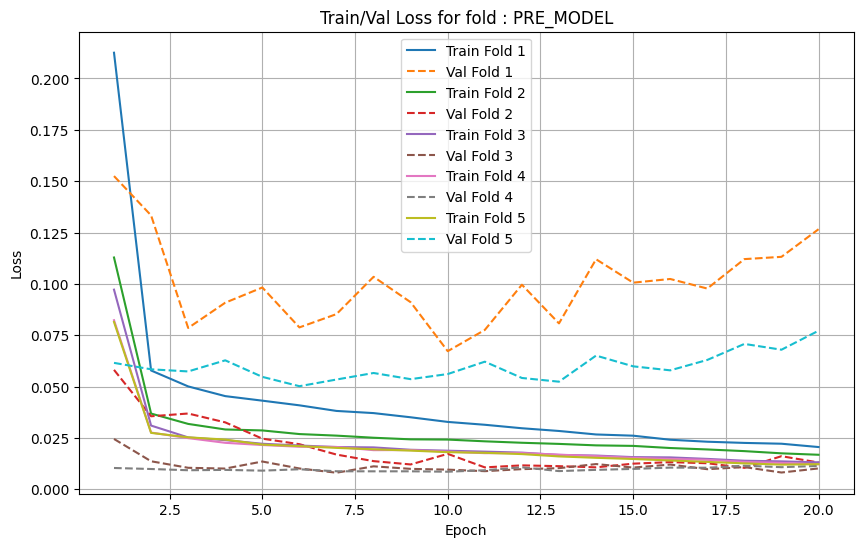

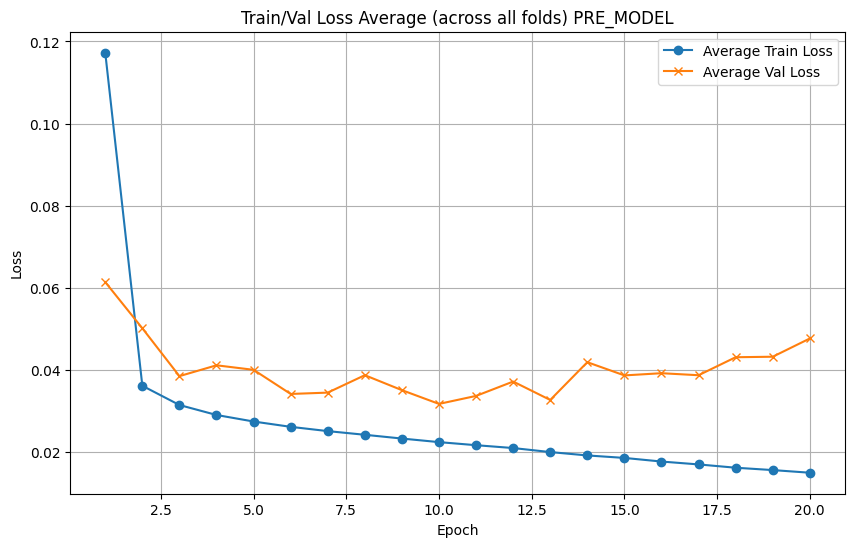

Best main-model parameters:
{'batch_size': 64, 'batch_size_pre': 64, 'dropout_value': 0, 'dropout_value_pre': 0, 'hidden_size': 128, 'hidden_size_pre': 128, 'learning_rate': 0.001, 'learning_rate_pre': 0.001, 'method_teacher': 'predicted', 'num_layers': 2, 'num_layers_pre': 2, 'proba_teacher': 1}
Achieved at epoch: 3
Mean Validation Loss: 0.08018988627904552


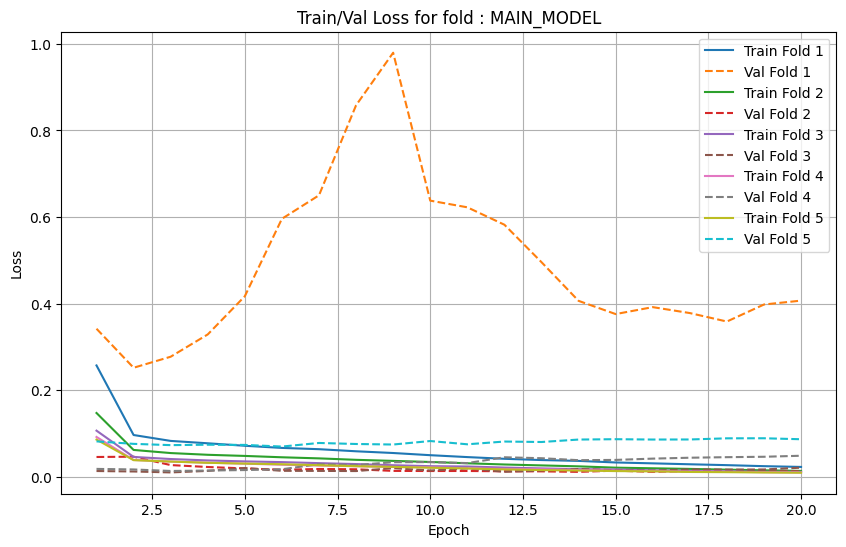

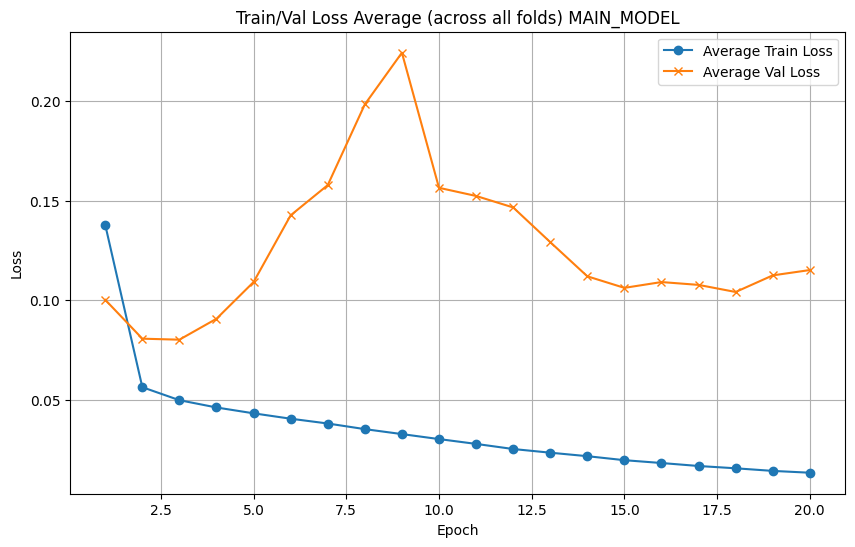

In [ ]:
if grid_search :
    grid_search_results_best=get_best_results_separately(grid_search_results)

----------------------------------------------
# OPTIMAL MODEL TRAINING


Now that we have the optimal hyperparameters, we will once more train the models with the obtained values.

## 1.   Setting Hyperparameters

These Hyperparameters are for the Pre-Model and the Main Model.

If `grid_search = True` in the earlier settings, then it automatically selects the optimal hyperparameters from the grid search, else if `False`, we manually define them.




In [ ]:
if grid_search :
    # For the pre-model optimal parameters:
    pre_opt = grid_search_results_best["best_pre"]["details"]
    hidden_size_pre_optim = pre_opt.get("hidden_size_pre_optim")
    num_layers_pre_optim  = pre_opt.get("num_layers_pre_optim")
    learning_rate_pre_optim = pre_opt.get("learning_rate_pre_optim")
    dropout_value_pre_optim = pre_opt.get("dropout_value_pre_optim")
    num_epochs_pre_optim = pre_opt.get("num_epochs_pre_optim")
    method_teacher_optim = pre_opt.get("method_teacher_optim")
    proba_teacher_optim = pre_opt.get("proba_teacher_optim")
    batch_size_pre_optim = grid_search_results_best["best_pre"]['params'].get("batch_size_pre")

    # For the main model optimal parameters:
    main_opt = grid_search_results_best["best_main"]["details"]
    hidden_size_optim = main_opt.get("hidden_size_optim")
    num_layers_optim  = main_opt.get("num_layers_optim")
    learning_rate_optim = main_opt.get("learning_rate_optim")
    dropout_value_optim = main_opt.get("dropout_value_optim")
    num_epochs_optim = main_opt.get("num_epochs_optim")
    batch_size_optim = grid_search_results_best["best_main"]['params'].get("batch_size")

    # For the pre-model optimal parameters:
else :
    # For the pre-model optimal parameters:
    hidden_size_pre_optim = 128
    num_layers_pre_optim = 2
    learning_rate_pre_optim = 1e-3
    dropout_value_pre_optim = 0
    num_epochs_pre_optim = 3
    batch_size_pre_optim = 64

    method_teacher_optim = "predicted"
    proba_teacher_optim = 1

    # For the main model optimal parameters:
    hidden_size_optim = 128
    num_layers_optim = 2
    learning_rate_optim = 1e-3
    dropout_value_optim = 0
    num_epochs_optim = 3
    batch_size_optim = 64

print("=====================================")
print("Optimal Pre-Model Hyperparameters:")
print(f"  hidden_size_pre_optim:   {hidden_size_pre_optim}")
print(f"  num_layers_pre_optim:    {num_layers_pre_optim}")
print(f"  learning_rate_pre_optim: {learning_rate_pre_optim}")
print(f"  dropout_value_pre_optim: {dropout_value_pre_optim}")
print(f"  num_epochs_pre_optim:    {num_epochs_pre_optim}")
print(f"  batch_size_pre_optim:     {batch_size_pre_optim}")
print("=====================================")
print(f"  method_teacher_optim:    {method_teacher_optim}")
print(f"  proba_teacher_optim:     {proba_teacher_optim}")
print("=====================================")
print("Optimal Main Model Hyperparameters:")
print(f"  hidden_size_optim:       {hidden_size_optim}")
print(f"  num_layers_optim:        {num_layers_optim}")
print(f"  learning_rate_optim:     {learning_rate_optim}")
print(f"  dropout_value_optim:     {dropout_value_optim}")
print(f"  num_epochs_optim:        {num_epochs_optim}")
print(f"  batch_size_optim:        {batch_size_optim}")
print("=====================================")

torch.manual_seed(SEED)

(
    train_df,
    _,
    scaler_optim,
    _,
    _,
    _,
    _,
) = prepare_pre_data_fold(
    train_data=train_data,
    train_idx=None,
    val_idx=None,
    kept_features_train=kept_features_train,
    kept_features_test=kept_features_test,
    n_steps_in=n_steps_in,
    n_steps_out=n_steps_out,
    batch_size=batch_size_pre_optim,
    pre_train=False,
)

(
    _,
    _,
    _,
    train_loader_pre,
    val_loader_pre,
    _,
    _,
) = prepare_pre_data_fold(
    train_data=train_data,
    train_idx=None,
    val_idx=None,
    kept_features_train=kept_features_train,
    kept_features_test=kept_features_test,
    n_steps_in=n_steps_in,
    n_steps_out=n_steps_out,
    batch_size=batch_size_optim,
    pre_train=True,
)

Optimal Pre-Model Hyperparameters:
  hidden_size_pre_optim:   128
  num_layers_pre_optim:    2
  learning_rate_pre_optim: 0.001
  dropout_value_pre_optim: 0
  num_epochs_pre_optim:    10
  batch_size_pre_optim:     64
  method_teacher_optim:    predicted
  proba_teacher_optim:     1
Optimal Main Model Hyperparameters:
  hidden_size_optim:       128
  num_layers_optim:        2
  learning_rate_optim:     0.001
  dropout_value_optim:     0
  num_epochs_optim:        3
  batch_size_optim:        64


## 2.  Training Optimal Pre-Model
Trains the final pre-model on the entire training dataset with optimal hyperparameters.



In [ ]:
# 2) TRAIN PRE-MODEL
model_pre_optim = LSTMModel(
    input_size=train_df.shape[1] - 1,
    hidden_size=hidden_size_pre_optim,
    num_layers=num_layers_pre_optim,
    n_steps_out=n_steps_out,
    output_size=1,
    dropout_value=dropout_value_pre_optim,
).to(device)

criterion_pre = nn.MSELoss()
optimizer_pre = optim.Adam(model_pre_optim.parameters(), lr=learning_rate_pre_optim)


train_losses_pre_list = []

print("Start training of pre-model")
for epoch in range(num_epochs_pre_optim):

    model_pre_optim.train()
    running_train_loss = 0.0
    for batch_X, batch_y in train_loader_pre:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer_pre.zero_grad()

        preds = model_pre_optim(batch_X)
        loss_pre = criterion_pre(preds, batch_y)
        loss_pre.backward()
        optimizer_pre.step()

        running_train_loss += loss_pre.item()

    train_loss_pre = running_train_loss / len(train_loader_pre)

    train_losses_pre_list.append(train_loss_pre)
    print(
        f"    [PRE] Epoch {epoch+1}/{num_epochs_pre_optim} "
        f"| Train: {train_loss_pre:.4f}"
    )

print( "Teacher forcing")

Start training of pre-model
    [PRE] Epoch 1/10 | Train: 0.0667
    [PRE] Epoch 2/10 | Train: 0.0279
    [PRE] Epoch 3/10 | Train: 0.0252
    [PRE] Epoch 4/10 | Train: 0.0239
    [PRE] Epoch 5/10 | Train: 0.0226
    [PRE] Epoch 6/10 | Train: 0.0221
    [PRE] Epoch 7/10 | Train: 0.0210
    [PRE] Epoch 8/10 | Train: 0.0203
    [PRE] Epoch 9/10 | Train: 0.0196
    [PRE] Epoch 10/10 | Train: 0.0190
Teacher forcing


## 3.  Teacher Forcing Predictions of Optimal Pre Model
Uses the trained pre-model `puissance_cvac` predictions and applies teacher forcing to the training data for the main model.


In [ ]:
# 3) TEACHER FORCING
train_data_windows = generate_overlapping_windows(
    train_df, window_size=n_steps_in, stride=1, Drop_last_column=True
)


preds_train_pre = make_predictions(train_data_windows, model_pre_optim)

pred_array = torch.stack(preds_train_pre).squeeze().numpy()

train_df_teacher_forced = apply_teacher_forcing(
    df=train_df,
    pred_array=pred_array,
    teacher_forcing_method=method_teacher_optim,
    p=proba_teacher_optim,
    target_column="puissance_cvac",
)


X_train, _ = create_sequences(train_df_teacher_forced, n_steps_in, n_steps_out)
_, y_train = create_sequences(train_df, n_steps_in, n_steps_out)


X_train_tensor = torch.from_numpy(X_train).double()
y_train_tensor = torch.from_numpy(y_train).double()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size_optim, shuffle=True)

Only using predicted values.


## 4.  Training Optimal Main Model
Trains the final Main Model on the (teacher-forced) training data using optimal hyperparameters.


In [ ]:
# 4) TRAIN THE MAIN MODEL
print( "Start training of main-model")

model_optim = LSTMModel(
    input_size=train_df.shape[1],
    hidden_size=hidden_size_optim,
    num_layers=num_layers_optim,
    n_steps_out=n_steps_out,
    output_size=1,
    dropout_value=dropout_value_optim,
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_optim.parameters(), lr=learning_rate_optim)

train_losses_list = []

for epoch in range(num_epochs_optim):
    model_optim.train()
    running_train_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()

        preds = model_optim(batch_X)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader)

    train_losses_list.append(train_loss)

    print(
        f"    [MAIN] Epoch {epoch+1}/{num_epochs_optim} " f"| Train: {train_loss:.4f}"
    )

Start training of main-model
    [MAIN] Epoch 1/3 | Train: 0.0802
    [MAIN] Epoch 2/3 | Train: 0.0412
    [MAIN] Epoch 3/3 | Train: 0.0380


-------------------------------------------------------
# PREDICTING THE TEST DATASET
Uses the trained models to generate final predictions on the test dataset.


## Scaling the test dataset
Scales the test dataset using the scaling parameters.


In [ ]:
common_indices = [kept_features_train.index(col) for col in kept_features_test]

# Extract the means and standard deviations for these columns
common_mean = scaler_optim.mean_[common_indices]
common_scale = scaler_optim.scale_[common_indices]

# Manually apply the transformation on the test set for these columns
test_data = test_data.copy()  # To avoid modifying the original DataFrame
test_common = test_data[kept_features_test].values  # Conversion to array to avoid name verifications
test_common_transformed = (test_common - common_mean) / common_scale

# Replace the columns in `test_data` with the standardized version
test_data[kept_features_test] = test_common_transformed
test_df = test_data.copy()

## Making predictions
Generates `puissance_cvac` predictions with the pre-model, adds them to test data, then generates final `puissance_cvac_future` predictions with the main model and un-scales them.


In [ ]:
# Generating time-series input windows
test_input_data_pre = generate_overlapping_windows(test_df, window_size=n_steps_in, stride=1)

# Make predictions using the pre-model
predictions_test_now = make_predictions(test_input_data_pre, model_pre_optim)
predictions_now_stacked = torch.cat(predictions_test_now, dim=0).squeeze()
predictions_now_stacked_array = predictions_now_stacked.cpu().numpy()
test_df['puissance_cvac'] = predictions_now_stacked_array

# Regenerating input windows from the updated `test_df`
test_input_data = generate_overlapping_windows(test_df, window_size=n_steps_in, stride=1)

# Make final predictions
predictions_test = make_predictions(test_input_data,model_optim)

In [ ]:
predictions_tensor = torch.stack(predictions_test)

preds_np = predictions_tensor.cpu().numpy().squeeze()
target_index = kept_features_train.index("puissance_cvac")
target_mean = scaler_optim.mean_[target_index]
target_scale = scaler_optim.scale_[target_index]

target_scale = float(target_scale)
target_mean = float(target_mean)

# Apply the inverse transformation.
predictions_unscaled = preds_np * target_scale + target_mean

print(predictions_unscaled)

[4.08576646 4.30042575 4.51839282 ... 5.71797063 5.8073582  5.87581417]


## Saving the model's predictions to a CSV file
Saves the final un-scaled predictions to a formatted CSV file.

In [ ]:
def write_predictions_to_csv(all_preds,kept_features_test,hidden_size,num_layers,learning_rate,num_epochs,dropout_value):
    """
    Writes the model's prediction results to a CSV file with a descriptive filename.

    Parameters:
        all_preds: The predicted values to be saved.
        kept_features_test: List of feature names used for testing, included in the filename.
        hidden_size: Hidden layer size of the model, included in the filename.
        num_layers: Number of LSTM layers, included in the filename.
        learning_rate: Learning rate used during training, included in the filename.
        num_epochs: Number of training epochs, included in the filename.
        dropout_value: Dropout rate used in the model, included in the filename.

    The function builds a DataFrame from the predictions, generates a timestamped and hyperparameter-rich filename,
    and saves the DataFrame to a CSV file without the index. It also prints a confirmation message with the filename and number of predictions.
    """
    # Build a DataFrame with ID starting at 0 and the prediction value.
    df = pd.DataFrame({"ID": range(len(all_preds)), "Prediction": all_preds})

    # Generate the filename using current date/time.
    filename = (
        f"Predictions{current_time}_"
        f"nIn{n_steps_in}_nOut{n_steps_out}_"
        f"bs{batch_size_optim}_"
        f"drop{dropout_value}_hs{hidden_size}_nl{num_layers}_"
        f"lr{learning_rate:.0e}_ep{num_epochs}_ftrs{''.join(kept_features_test)}.csv"
    )
    df.to_csv(filename, index=False)
    print(f"CSV file '{filename}' created with {len(all_preds)} predictions.")

In [ ]:
write_predictions_to_csv(predictions_unscaled.flatten(), kept_features_test,hidden_size_optim,num_epochs_optim,learning_rate_optim,num_epochs_optim,dropout_value_optim)

CSV file 'Predictions20250417_1636_nIn16_nOut16_bs64_drop0_hs128_nl3_lr1e-03_ep3_ftrstemperature_exterieurehumiditeensoleillementvitesse_venttemperature_interieure.csv' created with 35024 predictions.
